In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 10

# 1. Load Dataset + Merge

In [3]:
# Load in job listings data
postings = pd.read_csv('postings.csv')
print(postings.shape)
postings.head()

(123849, 31)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,30.0,Full-time,NaN,1.712858e+12,NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,60000.0,Full-time,NaN,1.713452e+12,NaN,https://www.linkedin.com/jobs/view/35982263/?t...,NaN,ComplexOnsiteApply,1.716044e+12,NaN,NaN,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [4]:
# Print proportion of nans per column
for col in postings.columns:
    na_vals = round(postings[col].isnull().sum()/postings.shape[0], 2)
    print(col, na_vals)

job_id 0.0
company_name 0.01
title 0.0
description 0.0
max_salary 0.76
pay_period 0.71
location 0.0
company_id 0.01
views 0.01
med_salary 0.95
min_salary 0.76
formatted_work_type 0.0
applies 0.81
original_listed_time 0.0
remote_allowed 0.88
job_posting_url 0.0
application_url 0.3
application_type 0.0
expiry 0.0
closed_time 0.99
formatted_experience_level 0.24
skills_desc 0.98
listed_time 0.0
posting_domain 0.32
sponsored 0.0
work_type 0.0
currency 0.71
compensation_type 0.71
normalized_salary 0.71
zip_code 0.17
fips 0.22


In [5]:
# Load in industries data
industries = pd.read_csv('companies/company_industries.csv')
industries.head()

,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting


In [6]:
# Merge with original data
postings = postings.merge(industries, on='company_id')
print(postings.shape)
postings.head()

(122121, 32)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,industry
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,Real Estate
1,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,Restaurants
2,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,Law Practice
3,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,HOURLY,"Raleigh, NC",1481176.0,9.0,NaN,14.0,Internship,4.0,1.713456e+12,NaN,https://www.linkedin.com/jobs/view/91700727/?t...,NaN,ComplexOnsiteApply,1.716048e+12,NaN,NaN,NaN,1.713456e+12,NaN,0,INTERNSHIP,USD,BASE_SALARY,35360.0,27601.0,37183.0,Non-profit Organizations
4,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,YEARLY,United States,81942316.0,7.0,NaN,60000.0,Contract,1.0,1.712861e+12,1.0,https://www.linkedin.com/jobs/view/103254301/?...,NaN,SimpleOnsiteApply,1.715453e+12,NaN,NaN,NaN,1.712861e+12,NaN,0,CONTRACT,USD,BASE_SALARY,180000.0,NaN,NaN,Design Services


In [7]:
# Load in skills data
skills = pd.read_csv('jobs/job_skills.csv')
skills.head()

,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


In [8]:
# Load in skills mapping data
skills_mapping = pd.read_csv('mappings/skills.csv').rename(columns={'skill_name': 'field'}) # Rename "skill_name" to "field"
skills_mapping.head()

,skill_abr,field
0,ART,Art/Creative
1,DSGN,Design
2,ADVR,Advertising
3,PRDM,Product Management
4,DIST,Distribution


In [9]:
# Merge skills df with corresponding mapping
fields = skills.merge(skills_mapping, on='skill_abr').drop(columns='skill_abr') # No Need for Skills' Abbreviations
fields.head()

,job_id,field
0,3884428798,Marketing
1,3884428798,Public Relations
2,3884428798,Writing/Editing
3,3887473071,Sales
4,3887465684,Finance


In [10]:
# Combine the corresponding skills for each job into 1 entry
grouped_fields = pd.DataFrame(fields.groupby('job_id')['field'].apply(lambda x: ', '.join(x))).reset_index()
grouped_fields

,job_id,field
0,921716,"Marketing, Sales"
1,1218575,Health Care Provider
2,1829192,Health Care Provider
3,2264355,"Design, Art/Creative, Information Technology"
4,10998357,"Management, Manufacturing"
...,...,...
126802,3906267117,"Legal, Business Development"
126803,3906267126,"Engineering, Information Technology"
126804,3906267131,"Sales, Business Development"
126805,3906267195,"Business Development, Sales"


In [11]:
# Merge the original dataset with the fields df
postings = postings.merge(grouped_fields, on='job_id')
print(postings.shape)
postings.head()

(120589, 33)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,industry,field
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,Real Estate,"Marketing, Sales"
1,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,Restaurants,"Management, Manufacturing"
2,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,Law Practice,Other
3,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,HOURLY,"Raleigh, NC",1481176.0,9.0,NaN,14.0,Internship,4.0,1.713456e+12,NaN,https://www.linkedin.com/jobs/view/91700727/?t...,NaN,ComplexOnsiteApply,1.716048e+12,NaN,NaN,NaN,1.713456e+12,NaN,0,INTERNSHIP,USD,BASE_SALARY,35360.0,27601.0,37183.0,Non-profit Organizations,Project Management
4,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,YEARLY,United States,81942316.0,7.0,NaN,60000.0,Contract,1.0,1.712861e+12,1.0,https://www.linkedin.com/jobs/view/103254301/?...,NaN,SimpleOnsiteApply,1.715453e+12,NaN,NaN,NaN,1.712861e+12,NaN,0,CONTRACT,USD,BASE_SALARY,180000.0,NaN,NaN,Design Services,"Design, Art/Creative, Information Technology"


In [12]:
# Impute the missing salaries with the median salary per industry
postings['normalized_salary'] = postings.groupby('industry')['normalized_salary'].transform(lambda x: x.fillna(x.median()))

In [13]:
postings

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,industry,field
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,Real Estate,"Marketing, Sales"
1,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,Restaurants,"Management, Manufacturing"
2,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,Law Practice,Other
3,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,HOURLY,"Raleigh, NC",1481176.0,9.0,NaN,14.0,Internship,4.0,1.713456e+12,NaN,https://www.linkedin.com/jobs/view/91700727/?t...,NaN,ComplexOnsiteApply,1.716048e+12,NaN,NaN,NaN,1.713456e+12,NaN,0,INTERNSHIP,USD,BASE_SALARY,35360.0,27601.0,37183.0,Non-profit Organizations,Project Management
4,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,YEARLY,United States,81942316.0,7.0,NaN,60000.0,Contract,1.0,1.712861e+12,1.0,https://www.linkedin.com/jobs/view/103254301/?...,NaN,SimpleOnsiteApply,1.715453e+12,NaN,NaN,NaN,1.712861e+12,NaN,0,CONTRACT,USD,BASE_SALARY,180000.0,NaN,NaN,Design Services,"Design, Art/Creative, Information Technology"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120584,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,195000.0,YEARLY,"Walnut Creek, CA",56120.0,1.0,NaN,120000.0,Full-time,NaN,1.713571e+12,NaN,https://www.linkedin.com/jobs/view/3906267117/...,NaN,ComplexOnsiteApply,1.716163e+12,NaN,Mid-Senior level,NaN,1.713571e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,94595.0,6013.0,Law Practice,"Legal, Business Development"
120585,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,NaN,NaN,United States,1124131.0,3.0,NaN,NaN,Full-time,NaN,1.713572e+12,1.0,https://www.linkedin.com/jobs/view/3906267126/...,https://www.pinterestcareers.com/en/jobs/58824...,OffsiteApply,1.716164e+12,NaN,Mid-Senior level,NaN,1.713572e+12,www.pinterestcareers.com,0,FULL_TIME,NaN,NaN,136925.0,NaN,NaN,Software Development,"Engineering, Information Technology"
120586,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,NaN,NaN,"Spokane, WA",90552133.0,3.0,NaN,NaN,Full-time,NaN,1.713572e+12,1.0,https://www.linkedin.com/jobs/view/3906267131/...,https://epsoperations.bamboohr.com/careers/122...,OffsiteApply,1.716164e+12,NaN,Mid-Senior level,NaN,1.713572e+12,epsoperations.bamboohr.com,0,FULL

# 2. Data Cleaning

In [14]:
# Create a copy of the data for cleaning
postings_cleaned = postings.copy()

In [15]:
# Columns to drop
postings_cleaned.drop(columns = [
    'max_salary', # Not interested in predicted max salary
    'pay_period', # "normalized_salary" accounts for pay period already
    'company_id', # Same as Company
    'med_salary', # Captured by "normalized_salary" already
    'original_listed_time', # Time format is uninterpretable
    'job_posting_url', # Too unique
    'application_url', # Too unique
    'expiry', # Time format is uninterpretable
    'min_salary', # Not interested in predicted min salary 
    'closed_time', # Time format is uninterpretable
    'listed_time', # Time format is uninterpretable 
    'fips', # Uninterpretable
    'currency', # Assumed to be USD based on the dataset
    'sponsored', # All 0s
    'remote_allowed', # High missingness
    'title', # High cardinality and information is generally captured by industry, field, and experience
    'skills_desc', # Not concerned about NLP
    'applies', # High missingness
    'compensation_type', # All the same
    'description', # Not concerned about NLP
    'work_type' # Already labeled as "formatted_work_type"
], inplace=True)

In [16]:
# Make "application_type" more interpretable
postings_cleaned['application_type'] = postings_cleaned['application_type'].str.replace(r'(?<!^)(?=[A-Z])', ' ', regex=True)

In [17]:
# Rename columns to make them more interpretable
postings_cleaned.rename(columns = {
    'company_name': "company",
    'formatted_work_type': "work_type", 
    'formatted_experience_level': 'experience',
    'compensation_type': 'compensation',
    'normalized_salary': 'median_salary'
}, inplace=True)

In [18]:
# Reformat "work_type" to make it more interpretable
postings_cleaned['work_type'] = postings_cleaned['work_type'].str.replace('-', ' ')
postings_cleaned['work_type'] = postings_cleaned['work_type'].str.title()

In [19]:
# Check the missingness for current columns
for col in postings_cleaned.columns:
    na_count = round(postings_cleaned[col].isnull().sum()/postings_cleaned.shape[0], 4)
    print(col, na_count)

job_id 0.0
company 0.0
location 0.0
views 0.0131
work_type 0.0
application_type 0.0
experience 0.2183
posting_domain 0.3039
median_salary 0.0001
zip_code 0.1637
industry 0.0
field 0.0


In [20]:
# Impute for columns with nans
postings_cleaned['views'].fillna(postings_cleaned['views'].median(), inplace=True)
postings_cleaned['experience'].fillna('Missing', inplace = True)
postings_cleaned.drop(columns = ['posting_domain'], inplace = True)
postings_cleaned['zip_code'].fillna(0, inplace = True)

In [21]:
# Check missignness now
for col in postings_cleaned.columns:
    na_count = round(postings_cleaned[col].isnull().sum()/postings_cleaned.shape[0], 3)
    print(col, na_count)

job_id 0.0
company 0.0
location 0.0
views 0.0
work_type 0.0
application_type 0.0
experience 0.0
median_salary 0.0
zip_code 0.0
industry 0.0
field 0.0


In [22]:
# Get rid of outliers based on the Interquartile Range rule
Q1 = postings_cleaned['median_salary'].quantile(0.25)
Q3 = postings_cleaned['median_salary'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

postings_cleaned = postings_cleaned[(postings_cleaned['median_salary'] >= lower_bound) & (postings_cleaned['median_salary'] <= upper_bound)]
print(postings_cleaned.shape)

(116445, 11)


In [23]:
# Convert all locations in "location" to a two letter abbreviation of the corresponding state
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
state_to_abbrev = {k.lower(): v for k, v in us_state_abbrev.items()}

# Load the cities to states mapping data
cities_df = pd.read_csv("cities_states.csv")
cities_df.columns = [col.strip().lower().replace(" ", "_") for col in cities_df.columns]

# Build a mapping from city (lowercase) to state abbreviation
city_to_state_abbrev = dict(zip(cities_df['city'].str.lower(), cities_df['state_id']))

# Define a function to convert a location string to its state abbreviation
def get_state_abbreviation(location):
    if pd.isnull(location):
        return "Other"
    loc = location.strip()
    
    # If the location contains a comma, try to parse parts
    if "," in loc:
        parts = [p.strip() for p in loc.split(",")]
        # If the second part is a two-letter state abbreviation (e.g., "AZ"), return it
        if len(parts) >= 2 and re.fullmatch(r"[A-Z]{2}", parts[-1]):
            return parts[-1]
        # If not, check if the first part is a state name (like "Arizona")
        potential_state = parts[0].lower()
        if potential_state in state_to_abbrev:
            return state_to_abbrev[potential_state]
    
    # Check if the entire location is a state name
    if loc.lower() in state_to_abbrev:
        return state_to_abbrev[loc.lower()]
    
    # Check if the location contains a state name within it
    for state_name, abbrev in state_to_abbrev.items():
        if state_name in loc.lower():
            return abbrev
    
    # Check if the location contains any known city name from the mapping
    for city, abbrev in city_to_state_abbrev.items():
        if city in loc.lower():
            return abbrev
    
    return "Other"

postings_cleaned['state'] = postings_cleaned['location'].apply(get_state_abbreviation)


In [24]:
postings_cleaned['state'].value_counts()

state
CA       11096
TX       10801
Other     7061
NY        6748
FL        5954
         ...  
VT         177
WY         128
ON           1
QC           1
PR           1
Name: count, Length: 55, dtype: int64

In [25]:
# Exclude the rare instances where there are locations that are not states in the US
postings_cleaned = postings_cleaned[
    (postings_cleaned['state'] != "ON") &
    (postings_cleaned['state'] != "QC") &
    (postings_cleaned['state'] != "PR")
]

In [26]:
postings_cleaned

,job_id,company,location,views,work_type,application_type,experience,median_salary,zip_code,industry,field,state
0,921716,Corcoran Sawyer Smith,"Princeton, NJ",20.0,Full Time,Complex Onsite Apply,Missing,38480.0,8540.0,Real Estate,"Marketing, Sales",NJ
1,10998357,The National Exemplar,"Cincinnati, OH",8.0,Full Time,Complex Onsite Apply,Missing,55000.0,45202.0,Restaurants,"Management, Manufacturing",OH
2,23221523,"Abrams Fensterman, LLP","New Hyde Park, NY",16.0,Full Time,Complex Onsite Apply,Missing,157500.0,11040.0,Law Practice,Other,NY
3,91700727,Downtown Raleigh Alliance,"Raleigh, NC",9.0,Internship,Complex Onsite Apply,Missing,35360.0,27601.0,Non-profit Organizations,Project Management,NC
5,1218575,Children's Nebraska,"Omaha, NE",3.0,Full Time,Offsite Apply,Missing,76788.0,68102.0,Hospitals and Health Care,Health Care Provider,NE
...,...,...,...,...,...,...,...,...,...,...,...,...
120584,3906267117,Lozano Smith,"Walnut Creek, CA",1.0,Full Time,Complex Onsite Apply,Mid-Senior level,157500.0,94595.0,Law Practice,"Legal, Business Development",CA
120585,3906267126,Pinterest,United States,3.0,Full Time,Offsite Apply,Mid-Senior level,136925.0,0.0,Software Development,"Engineering, Information Technology",Other
120586,3906267131,EPS Learning,"Spokane, WA",3.0,Full Time,Offsite Apply,Mid-Senior level,60500.0,99201.0,Education Administration Programs,"Sales, Business Development",WA
120587,3906267195,Trelleborg Applied Technologies,"Texas, United States",4.0,Full Time,Complex Onsite Apply,Missing,65000.0,0.0,Industrial Machinery Manufacturing,"Business Development, Sales",TX


# 3. EDA

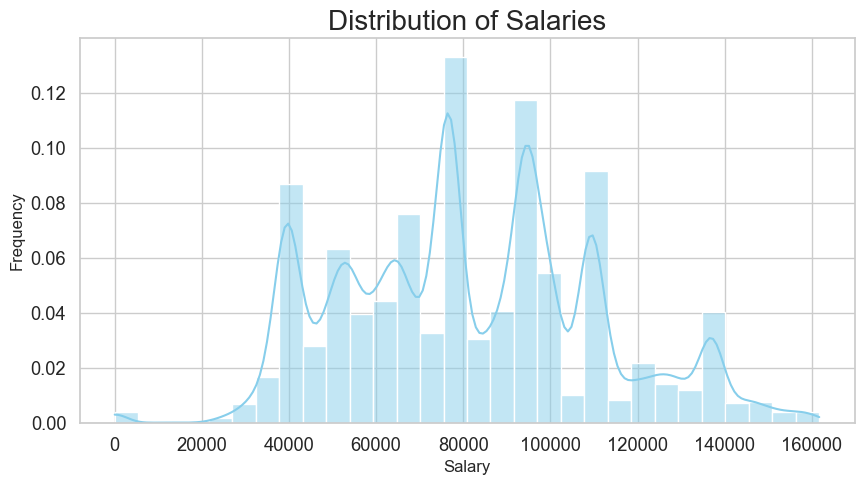

In [27]:
# Histogram of the distribution of salaries
plt.figure(figsize=(10, 5))

sns.set_theme(style="whitegrid", context="talk")
sns.set_context("notebook", font_scale=1.2)


sns.histplot(data=postings_cleaned, x="median_salary", bins=30, kde=True, color="skyblue", stat='probability')

plt.xlabel("Salary", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Salaries", fontsize=20)
plt.show()

In [28]:
# Create a new column to describe if a salary falls above or below the national median salary in 2024
postings_cleaned['above_median'] = postings_cleaned['median_salary'] >= 60000

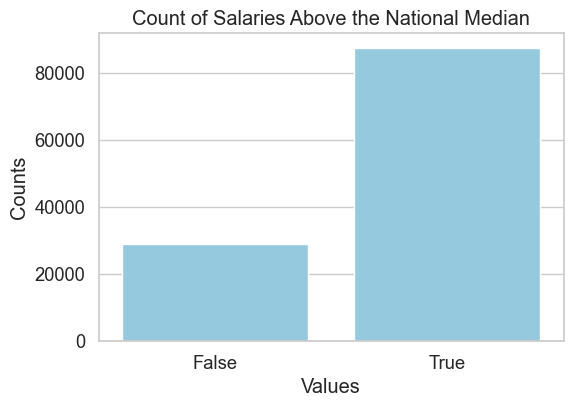

In [ ]:
# Bar plot of the distribution of trues and falses for salaries above the nation median
counts = postings_cleaned['above_median'].value_counts().reset_index()
counts.columns = ['above_median', 'count']

plt.figure(figsize=(6, 4))
sns.barplot(x='above_median', y='count', data=counts, color="skyblue")
plt.xlabel('Values')
plt.ylabel('Counts')
plt.title('Count of Salaries Above the National Median')
plt.show()

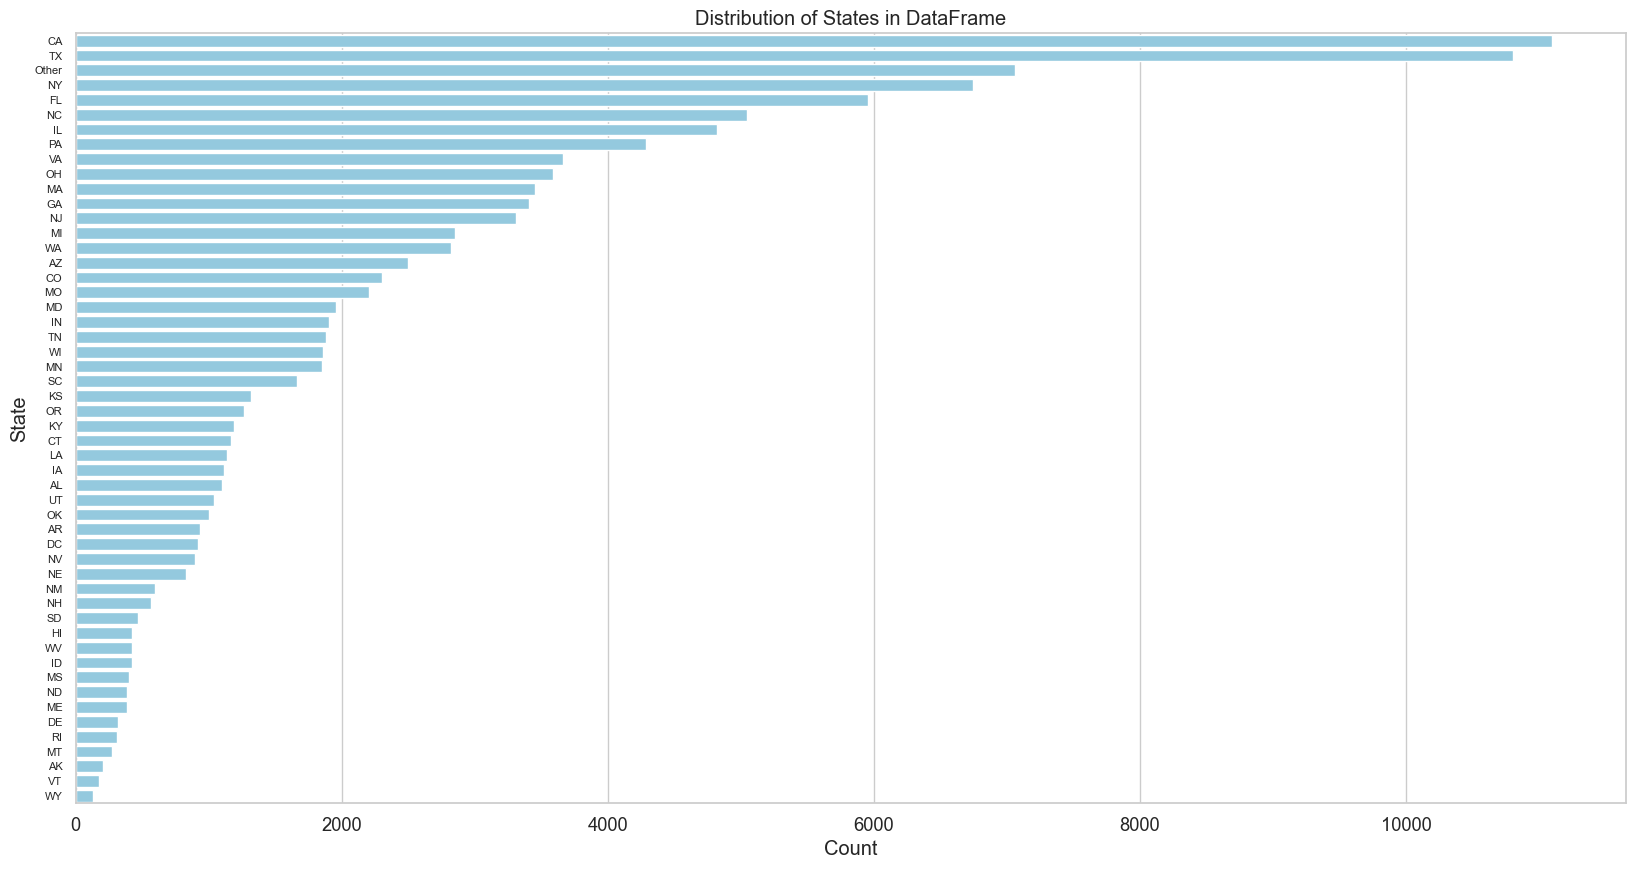

In [ ]:
# Bar plot of the distribution of states
plt.figure(figsize=(20, 10))
sns.countplot(y='state', data=postings_cleaned, order=postings_cleaned['state'].value_counts().index, color="skyblue")
plt.xlabel('Count')
plt.ylabel('State')
plt.yticks(fontsize = 8)
plt.title('Distribution of States in DataFrame')
plt.show()

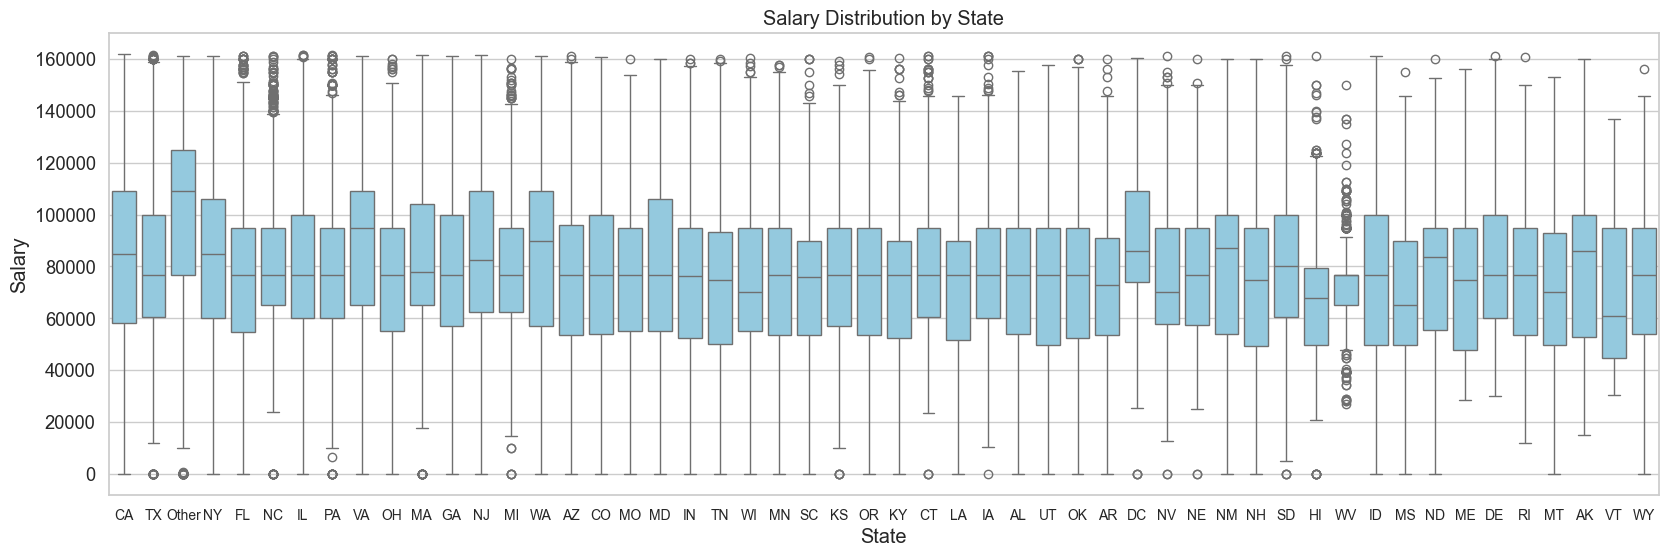

In [ ]:
# Box plot of salaries per state
plt.figure(figsize=(20, 6))
sns.boxplot(x='state', y='median_salary', data=postings_cleaned, order=postings_cleaned['state'].value_counts().index, color="skyblue")
plt.xlabel('State')
plt.xticks(fontsize=10)
plt.ylabel('Salary')
plt.title('Salary Distribution by State')
plt.show()

In [ ]:
# Create a df to ungroup the fields in the 'field' column so it is easier to plot
ungrouped_skills = postings_cleaned.merge(fields, on='job_id')

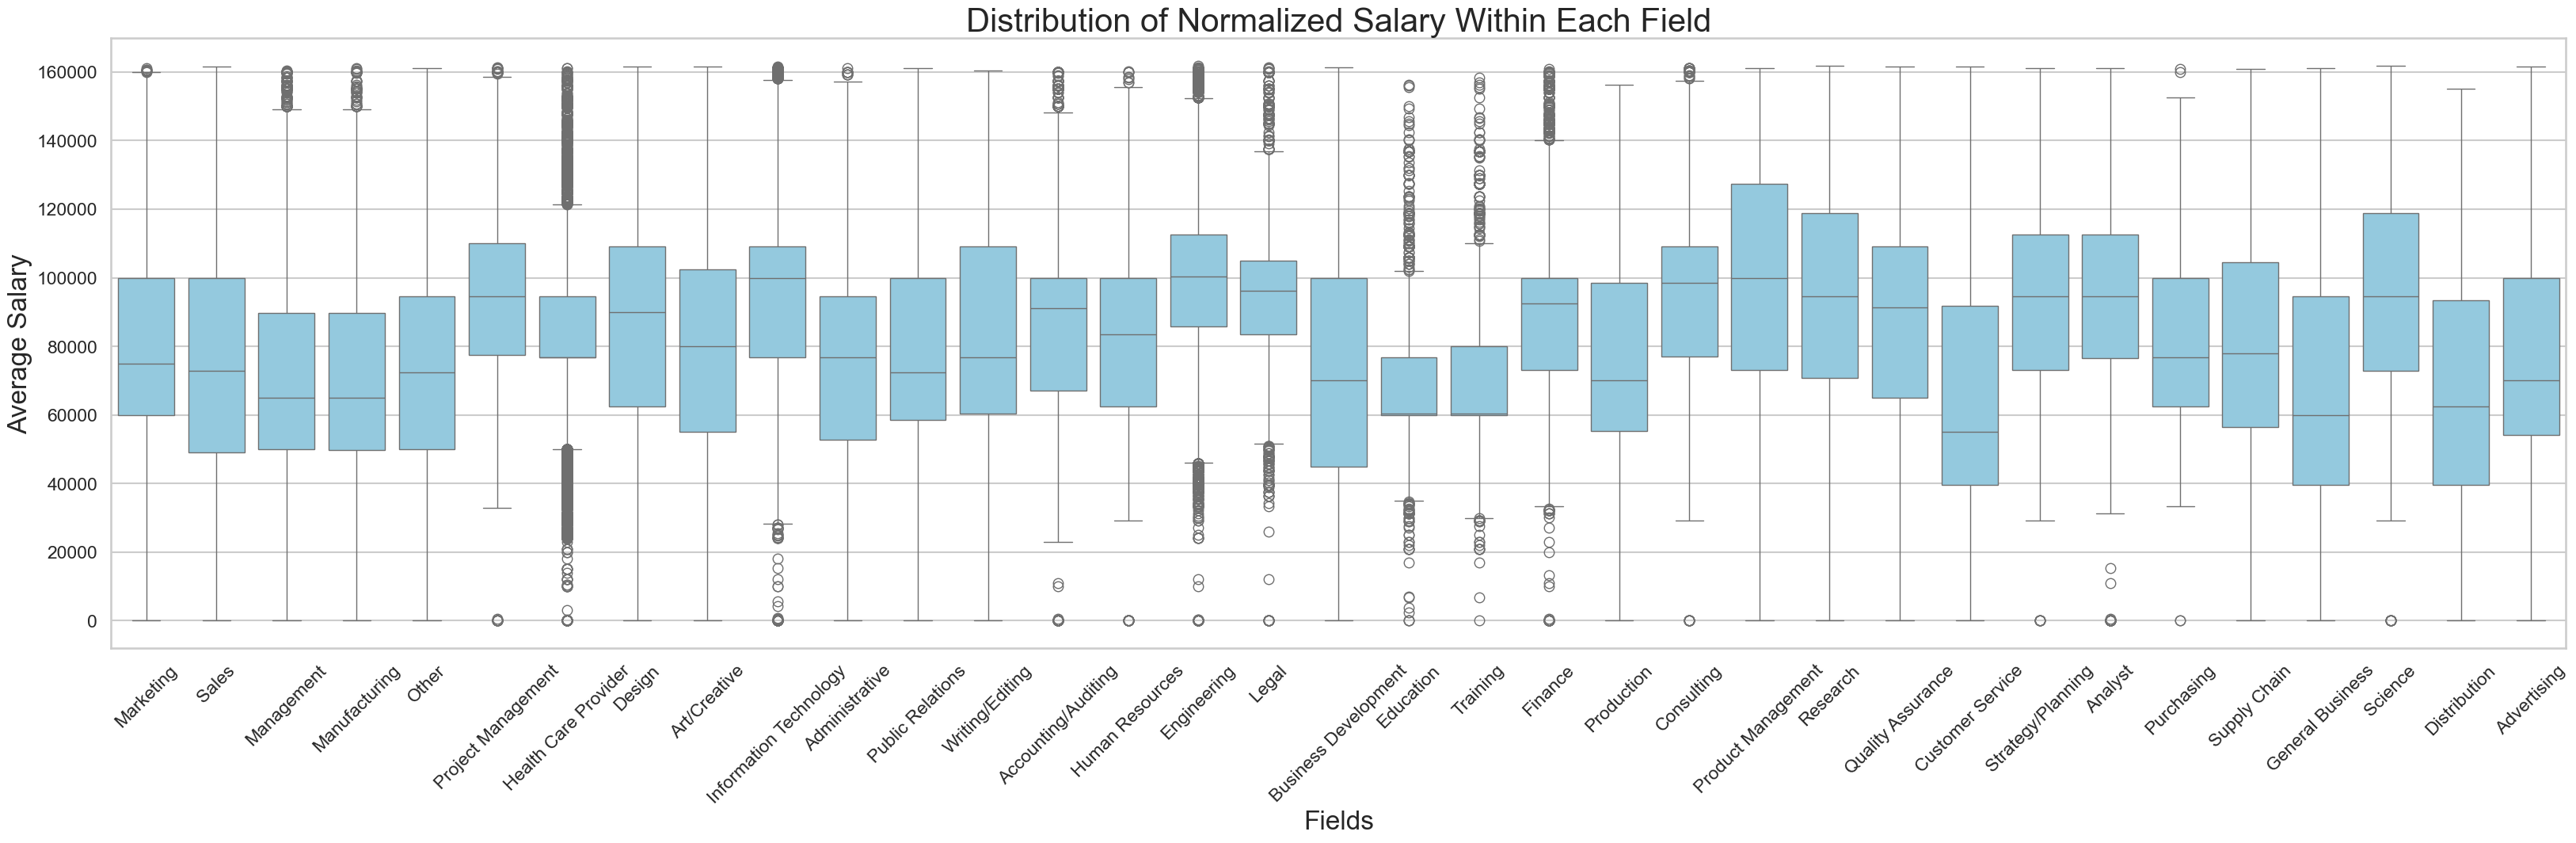

In [ ]:
# Box plot of salaries per field
plt.figure(figsize=(40, 10))

sns.set_theme(style="whitegrid", context="talk")
sns.boxplot(x='field_y', y='median_salary', data=ungrouped_skills, color="skyblue")

plt.xticks(rotation=45)

plt.xlabel('Fields', fontsize=24)
plt.ylabel('Average Salary', fontsize=24)
plt.title('Distribution of Normalized Salary Within Each Field', fontsize=30)

plt.show()

# 4. Data Processing

In [ ]:
# Categorical columns that need to be processed
cat_cols = [
    'company',
    'work_type',
    'experience',
    'industry',
    'state',
    'application_type'
]

for cat in cat_cols:
    print(cat, postings_cleaned[cat].nunique())

company 22853
work_type 7
experience 7
industry 138
state 52
application_type 4


In [ ]:
# Create a copy of the cleaned df for data processing
postings_processed = postings_cleaned.copy()
postings_processed.drop(columns = ['job_id', 'location'], inplace=True)

In [ ]:
# One hot encode the columns with lower cardinality
one_hot_cols = ['work_type', 'experience', 'application_type']
postings_processed = pd.get_dummies(postings_processed, columns=one_hot_cols, drop_first=True)

In [ ]:
# Split the fields within the "field" column then multi-label encode it
def split_fields(x):
    if not isinstance(x, str):
        return []
    return [field.strip() for field in x.split(',')]

postings_processed['field_list'] = postings_processed['field'].apply(split_fields)

mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(postings_processed['field_list'])

encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=postings_processed.index)

postings_processed = pd.concat([postings_processed, encoded_df], axis=1)

postings_processed.drop(['field', 'field_list'], axis=1, inplace=True)

In [ ]:
# Frequency encode the columns with high cardinality
high_card_cols = ['company', 'industry']

for col in high_card_cols:
    freq_map = postings_processed[col].value_counts()
    postings_processed[col + '_freq'] = postings_processed[col].map(freq_map)
    postings_processed.drop(col, axis=1, inplace=True)

In [ ]:
# Map each state in the data to one of five regions in the US (reduce cardinality) then one-hot encode
state_to_region = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West',
    'CO': 'West', 'CT': 'Northeast', 'DE': 'South', 'DC': 'South', 'FL': 'South',
    'GA': 'South', 'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest',
    'IA': 'Midwest', 'KS': 'Midwest', 'KY': 'South', 'LA': 'South', 'ME': 'Northeast',
    'MD': 'South', 'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South',
    'MO': 'Midwest', 'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast',
    'NJ': 'Northeast', 'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest',
    'OH': 'Midwest', 'OK': 'South', 'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast',
    'SC': 'South', 'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West',
    'VT': 'Northeast', 'VA': 'South', 'WA': 'West', 'WV': 'South', 'WI': 'Midwest',
    'WY': 'West'
}

postings_processed['region'] = postings_processed['state'].map(state_to_region)

postings_processed['region'].fillna('Other', inplace=True)

postings_processed.drop('state', axis=1, inplace=True)

postings_processed = pd.get_dummies(postings_processed, columns=['region'], drop_first=True)

In [41]:
postings_processed

,views,median_salary,zip_code,above_median,work_type_Full Time,work_type_Internship,work_type_Other,work_type_Part Time,work_type_Temporary,work_type_Volunteer,experience_Director,experience_Entry level,experience_Executive,experience_Internship,experience_Mid-Senior level,experience_Missing,application_type_Offsite Apply,application_type_Simple Onsite Apply,application_type_Unknown Apply,Accounting/Auditing,Administrative,Advertising,Analyst,Art/Creative,Business Development,Consulting,Customer Service,Design,Distribution,Education,Engineering,Finance,General Business,Health Care Provider,Human Resources,Information Technology,Legal,Management,Manufacturing,Marketing,Other,Product Management,Production,Project Management,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing,company_freq,industry_freq,region_Northeast,region_Other,region_South,region_West
0,20.0,38480.0,8540.0,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1802,True,False,False,False
1,8.0,55000.0,45202.0,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,623,False,False,False,False
2,16.0,157500.0,11040.0,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,785,True,False,False,False
3,9.0,35360.0,27601.0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,1821,False,False,True,False
5,3.0,76788.0,68102.0,True,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,15423,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120584,1.0,157500.0,94595.0,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,785,False,False,False,True
120585,3.0,136925.0,0.0,True,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,4920,False,True,False,False
120586,3.0,60500.0,99201.0,True,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,941,False,False,False,True
120587,4.0,65000.0,0.0,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1626,False,False,True,False


# 5.1. Baseline Model (Continuous Salary)

In [ ]:
# Baseline model using gradient boosting
X = postings_processed.drop(columns = ['median_salary', 'above_median'])
y = postings_processed["median_salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Baseline MAE:", mae)
print(f"XGBoost Baseline R²:", r2)

XGBoost Baseline MAE: 10844.74571513107
XGBoost Baseline R²: 0.6436739480258052


In [ ]:
# Baseline model using a random forest
X = postings_processed.drop(columns = ['median_salary', 'above_median'])
y = postings_processed['median_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor Baseline MAE:", mae)
print("Random Foreset Regressor Baseline R2: ", r2)

Random Forest Regressor Baseline MAE: 9372.774019200548
Random Foreset Regressor Baseline R2:  0.662373551058278


# 5.2. Feature Engineering (From EDA)

In [ ]:
# Add in "above_median" feature (boolean feature that describes if a salary is above the national median for 2024) created during EDA
X = postings_processed.drop(columns = ['median_salary'])
y = postings_processed['median_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor New MAE:", mae)
print("Random Foreset Regressor New R²: ", r2)

Random Forest Regressor New MAE: 6111.000807217907
Random Foreset Regressor New R²:  0.8318773535425175


# 5.3. Hyperparameter Tuning (Continuous Salary)

In [46]:
# Hyperparameter tune the random forest model to improve predictive performance
X = postings_processed.drop("median_salary", axis=1)
y = postings_processed["median_salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': [200, 400],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,              
    cv=5,                   
    scoring='neg_mean_squared_error',
    n_jobs=-1,              
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation (negative MSE) score:", random_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.7min
[CV] END min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 5.3min
[CV] END min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.7min
[CV] END min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.7min
[CV] END min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 5.4min
[CV] END min_samples_leaf=2, min_samples_split=5, n_estimators=400;

In [47]:
# Evaluate final model on test data
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Tuned Random Forest MAE:", mae)
print(f"Tuned Random Forest R²", r2)

Tuned Random Forest MAE: 6028.888272635409
Tuned Random Forest R² 0.8375737960137345


# Bonus 6.1. Baseline Model (Binary Salary)

In [ ]:
X = postings_processed.drop(columns = ['median_salary', 'above_median'])
y = postings_processed['above_median']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Random Forest Classifier Results:")
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


# Bonus 6.2. Hyperparameter Tuning (Binary Salary)

In [ ]:
X = postings_processed.drop(columns=['median_salary', 'above_median'])
y = postings_processed['above_median']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': [100, 200],  
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4], 
    'bootstrap': [True, False] 
}

rfc = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

In [ ]:
best_rfc = random_search.best_estimator_
y_pred = best_rfc.predict(X_test)
y_pred_proba = best_rfc.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Tuned Random Forest Classifier Results:")
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)